In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
import glob
import os


import seaborn as sns
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Wavelet for one subject, all channels

In [23]:
sub = '01'
period = 'pre'
task = 'listen'
channels = 'Cz'

wavelet_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz_{channels}/'
data = loadmat(os.path.join(wavelet_path, f'{task}_wavelet_{period}_{sub}.mat'))
wavelet_transform = data['wavelet_transform']

wavelet_trans_info = loadmat(os.path.join(wavelet_path,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

wavelet_transform_mean = np.mean(wavelet_transform, axis = 0)

#### Plot scaleogram for one channel

Text(0.5, 1.0, 'Cz channel, listen pre sub 01')

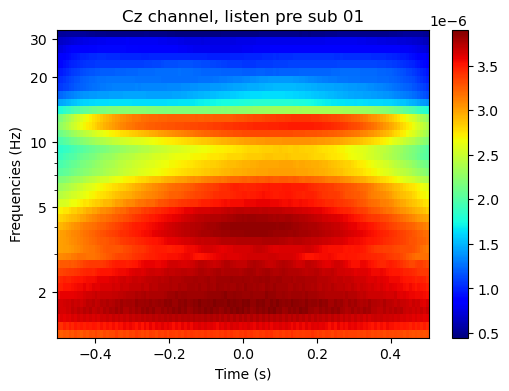

In [ ]:
channel = ['Cz']
#ch_idx = ch_index(channel)
ch_idx = 0 #working on arrays with only one channel index


test_wavelet = np.squeeze(wavelet_transform_mean[ch_idx,:,:])
plot_scaleogram(test_wavelet, freqs, times) 
plt.title(f'{channel[0]} channel, {task} {period} sub {sub}')

#### Plot topomap for a frequency band

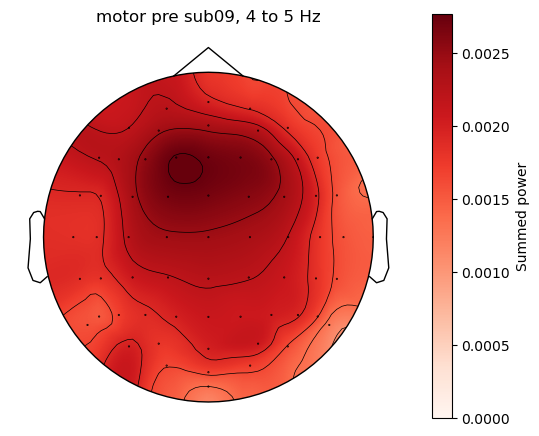

In [ ]:
freq_band = [4,5] #10-15 for beta, 4-5 for listening-related ERP
power_ch = sum_over_channels(wavelet_transform_mean, freq_band, freqs)

fig, ax = plt.subplots()
ax.set_title(f'{task} {period} sub{sub}, {freq_band[0]} to {freq_band[1]} Hz')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Summed power')

#plot this last
pos = load_ep_info()
im, _=mne.viz.plot_topomap(power_ch, pos, axes = ax)



### Wavelet for multiple subjects

In [4]:
def power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum):

    """ 
    NOTES: Currently assumes that all data contains only one channel

    Averages the wavelets over trials before processing

    Sums the power over time for multiple subjects
    freqs_to_sum: Range of freqs to sum over from low to high bound, or 'all'
        if 'all', the dataframe will return power as arrays of size freqs x power
    
    ---
    returns: dataframe with colums for subjects, periods, musicianship, and summed power at each frequency
    """
    #task = wavelet_dir.split("/")[-1].split('_')[2]

    info_path = os.path.join(wavelet_dir, "wavelet_record.mat")
    wavelet_trans_info = loadmat(info_path)
    freqs = wavelet_trans_info['freqs'][0]

    power_df = pd.DataFrame(columns=['subject', 'musician', 'period', 'power'])
    _, _, musicians, _ = load_subject_lists()

    for wavelet_file in sorted(os.listdir(wavelet_dir)):
        sub_id = wavelet_file.split(".")[0].split('_')[-1]
        period =  wavelet_file.split(".")[0].split('_')[-2]

        if sub_id not in subjects_to_process:
            # print(f'skipping sub {sub_id}')
            continue
        
        #print('proccessing', wavelet_file)
        data = loadmat(os.path.join(wavelet_dir, wavelet_file))
        wavelet_sub = data['wavelet_transform']
        wavelet_sub_ave = np.mean(wavelet_sub, axis = 0).squeeze()

        #take subset that is relevant for the frequency
        if isinstance(freqs_to_sum, str) and freqs_to_sum == 'all':
            power_arr = np.zeros(wavelet_sub_ave.shape[0])
            for i, freq in enumerate(freqs): 
                
                power = sum_wavelet_power(wavelet_sub_ave, [freq], freqs)
                power_arr[i] = power
        else:
            power_arr = sum_wavelet_power(wavelet_sub_ave, freqs_to_sum, freqs)
            
        
        #add to dataframe
        power_df_sub = pd.DataFrame({
            'subject': sub_id,
            'period': period,
            'power': [power_arr]

        })
        if sub_id in musicians:
            power_df_sub['musician'] = 1
        else: 
            power_df_sub['musician'] = 0
        power_df = pd.concat([power_df, power_df_sub])

    return power_df
            


In [5]:
def find_existing_subjects(data_dir):
    """ 
    automatically find subjects existing in the evoked or epochs folder
    NEED TO BETTER DEFINE HOW TO HANDLE PERIODS, for now it's not relevant
    (subjects are expected to have data in both pre and post periods)
    ---
    returns:
    subjects_to_process: list of subjects
    """
    
    subjects_to_process = []
    for file_name in os.listdir(data_dir):
        # Check if the file matches the format you're interested in

            # Extract the subject ID (last two characters before file extension name)
            subject_id = file_name.split("_")[-1].split(".")[0]
            subjects_to_process.append(subject_id)

    # Sort and filter the list of subjects
    subjects_to_process = sorted(set(subjects_to_process))
    subjects_to_process = [x for x in subjects_to_process if x.isdigit()] 
    return subjects_to_process

In [11]:
wavelet_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_listen__n05to05_30Hz_Cz'
subjects_to_process = find_existing_subjects(wavelet_dir)

wavelet_trans_info = loadmat(os.path.join(wavelet_dir,f'wavelet_record.mat'))
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

#### Initialize directories

In [12]:
period = 'pre'
task = 'listen'
channels = 'Cz'



wavelet_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_listen__n05to05_30Hz_Cz'
power_df_all = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum='all')
power_df_45 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[4,5])
power_df_1015 = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum=[10,15])

power_musicians_pre = power_df_all.query("musician == 1 & period == 'pre'")
power_musicians_post = power_df_all.query("musician == 1 & period == 'post'")
power_nonmusicians_pre = power_df_all.query("musician == 0 & period == 'pre'")
power_nonmusicians_post = power_df_all.query("musician == 0 & period == 'post'")

In [13]:
def plot_power_freqs(freqs, power_data, label = None, color = None):

    if isinstance (power_data, pd.DataFrame):
    # Assuming power_df_all['power'] is a 2D array where rows are observations (e.g., trials or subjects) and columns are frequencies
        power = np.array(power_data['power'].tolist())  # Convert to numpy array if it's not already
    else: 
        assert isinstance(power_data, np.ndarray)
        power = power_data
    power_mean = power.mean(axis=0)  # Mean across observations
    power_sem = power.std(axis=0, ddof=1) / np.sqrt(power.shape[0])  # SEM computation

    # Plot the mean power spectrum
    plt.plot(freqs, power_mean, label = label, color = color)

    # Add SEM as a shaded region
    plt.fill_between(freqs, 
                    power_mean - power_sem, 
                    power_mean + power_sem, 
                    color = color,
                    alpha=0.3)
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')

Text(0.5, 1.0, 'Musicians')

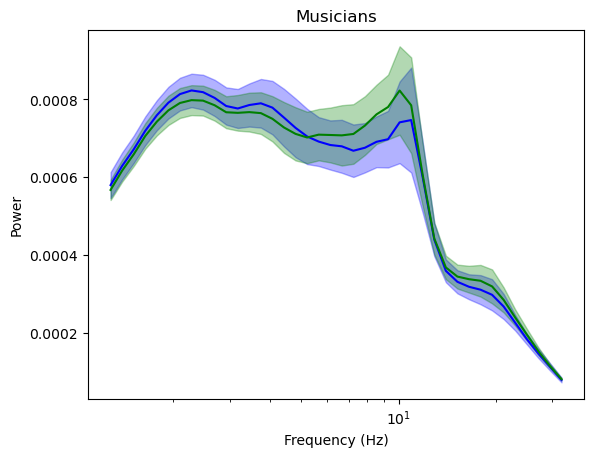

In [14]:
plot_power_freqs(freqs, power_musicians_pre, color = 'blue', label = 'pre')
plot_power_freqs(freqs, power_musicians_post, color = 'green', label = 'post')
plt.title('Musicians')

Difference in power

In [26]:
power_diff = power_nonmusicians_post['power']-power_nonmusicians_pre['power']
power_diff = np.vstack(power_diff)

Text(0.5, 1.0, 'listen difference post-pre, nonmusicians')

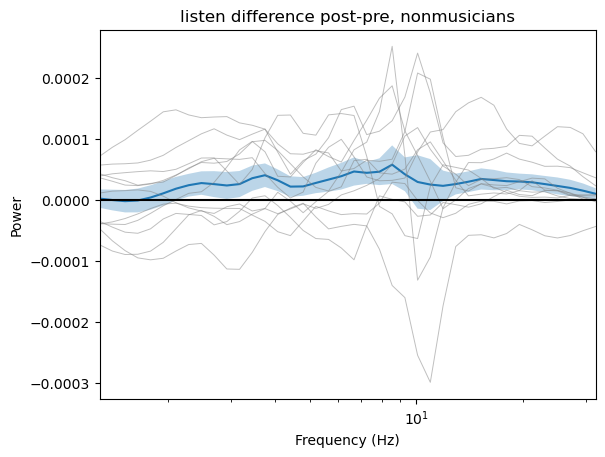

In [27]:
plot_power_freqs(freqs,power_diff)
for sub in range(power_diff.shape[0]):
    plt.plot(freqs, power_diff[sub, :], color = 'grey', alpha = 0.5, linewidth = 0.7)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])
plt.title(f'{task} difference post-pre, nonmusicians')

In [57]:
def find_power_diff(power_df):
    """ 
    Finds post-pre values for a given power dataframe
    ---
    Returns a dataframe with pre, post, and difference
        TO DO: get rid of the pre and post to save on memory??
    """
    power_pivot = power_df.pivot(index =[ 'subject', 'musician'], columns = 'period', values = 'power')
    power_pivot['diff'] = power_pivot['post'] - power_pivot['pre']
    return power_pivot

In [58]:
power_diff_1015 = find_power_diff(power_df_1015)
power_diff_45 = find_power_diff(power_df_45)

Text(0.5, 1.0, 'Power difference post - pre, 4-5 Hz')

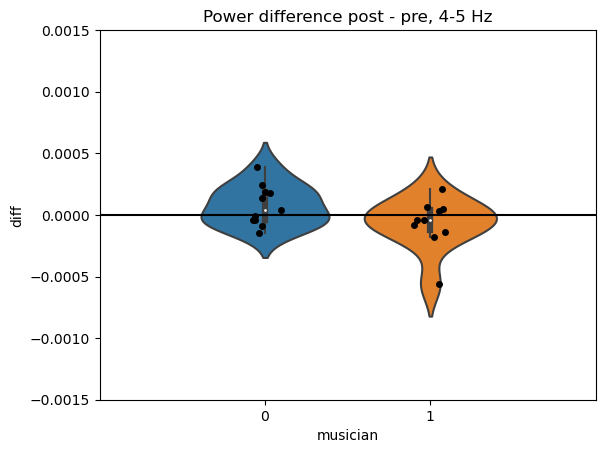

In [85]:
sns.violinplot(data=power_diff_45, x = power_diff_45.index.get_level_values(1), y = 'diff')
sns.stripplot(data=power_diff_45, x = power_diff_45.index.get_level_values(1), y = 'diff', color = 'black')
plt.hlines(0, -1,2, color = 'black')

plt.xlim(-1,2)
plt.ylim(-0.0015, 0.0015)
plt.title('Power difference post - pre, 4-5 Hz')


Power over a band

(0.0, 0.008)

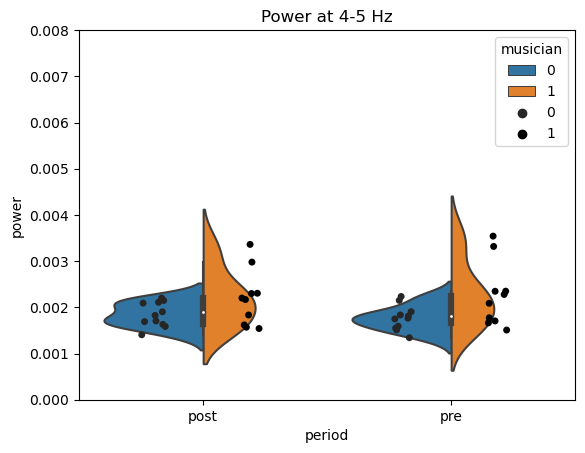

In [17]:
sns.violinplot(data = power_df_45, x = 'period', y = 'power', hue = 'musician', split = True)
sns.stripplot(data = power_df_45, x = 'period', y = 'power', hue = 'musician', color = 'black', dodge=True)
plt.title('Power at 4-5 Hz')
plt.ylim(0, 0.008)